In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve


from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules


import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:

churn_df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
retail_df = pd.read_excel('/content/online_retail_II.xlsx')


print("Churn Data Sample:")
display(churn_df.head())

print("\nOnline Retail Sample:")
display(retail_df.head())


Churn Data Sample:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Online Retail Sample:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


##Question 1 – Customer Churn Prediction

Data Preprocessing

In [4]:

churn_df['TotalCharges'] = churn_df['TotalCharges'].replace(' ', np.nan)
churn_df.dropna(subset=['TotalCharges'], inplace=True)
churn_df['TotalCharges'] = churn_df['TotalCharges'].astype(float)


for col in churn_df.columns:
    if churn_df[col].dtype == 'object':
        le = LabelEncoder()
        churn_df[col] = le.fit_transform(churn_df[col])


X = churn_df.drop('Churn', axis=1)
y = churn_df['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training (Random Forest)

In [5]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


Evaluation + Visuals

Accuracy: 0.7917555081734187

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.86      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



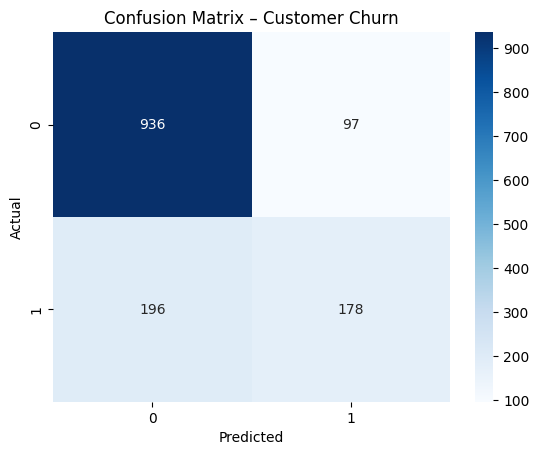

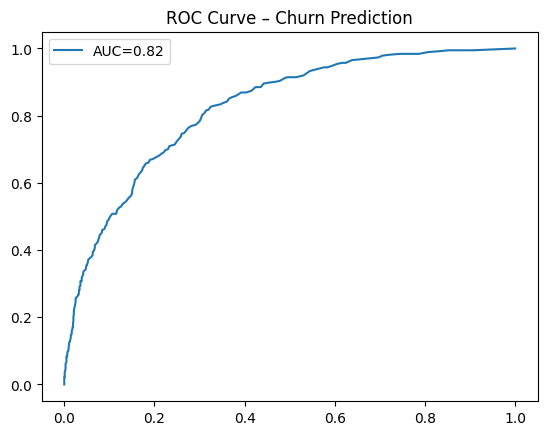

In [6]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Customer Churn')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(roc_auc_score(y_test, y_pred_proba),2)))
plt.legend(); plt.title('ROC Curve – Churn Prediction'); plt.show()


Feature Importance

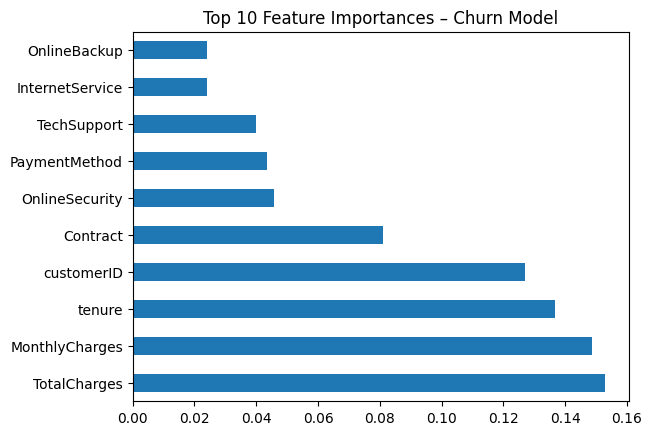

In [7]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
importances.plot(kind='barh')
plt.title('Top 10 Feature Importances – Churn Model')
plt.show()


##Question 2 – Customer Segmentation (Online Retail)

Data Cleaning

In [10]:
print(retail_df.info())
print(retail_df.head())


retail_df = retail_df.dropna(subset=['Customer ID', 'Description'])


retail_df['Customer ID'] = retail_df['Customer ID'].astype(int)


retail_df = retail_df[retail_df['Quantity'] > 0]


retail_df['totalprice'] = retail_df['Quantity'] * retail_df['Price']


print("After cleaning:")
print(retail_df.describe(include='all'))
print(retail_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 407695 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  int64         
 7   Country      407695 non-null  object        
 8   totalprice   407695 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.1+ MB
None
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERR

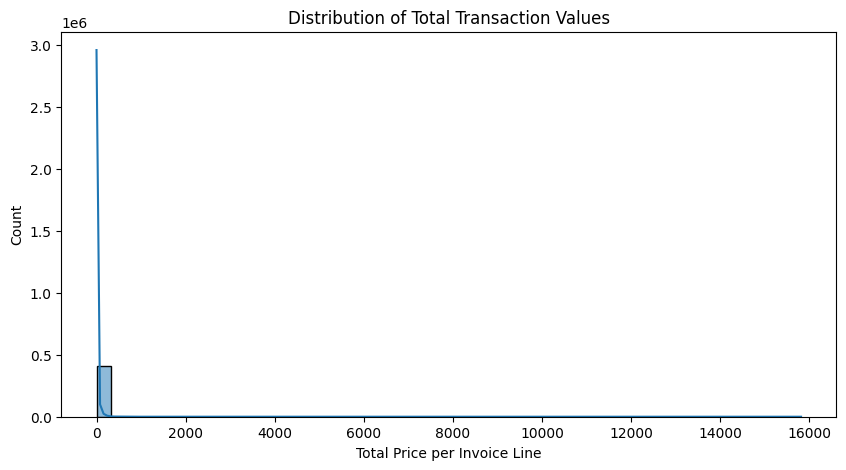

In [11]:


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(retail_df['totalprice'], bins=50, kde=True)
plt.title('Distribution of Total Transaction Values')
plt.xlabel('Total Price per Invoice Line')
plt.ylabel('Count')
plt.show()

RFM (Recency, Frequency, Monetary) Analysis

In [12]:

rfm = retail_df.groupby('customerid').agg({
    'invoicedate': lambda x: (retail_df['invoicedate'].max() - x.max()).days,
    'invoice': 'count',
    'totalprice': 'sum'
}).rename(columns={'invoicedate': 'recency', 'invoice': 'frequency', 'totalprice': 'monetary'})

rfm.reset_index(inplace=True)
rfm.head()


,Customer ID,recency,frequency,monetary
0,12346,164,33,372.86
1,12347,2,71,1323.32
2,12348,73,20,222.16
3,12349,42,102,2671.14
4,12351,10,21,300.93


: Scale & Cluster (K-Means)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])


kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)


print(rfm.groupby('cluster').mean())


          Customer ID     recency    frequency       monetary
cluster                                                      
0        15334.840728   43.057772    84.812959    1592.729466
1        15403.817308  243.004808    29.875962     614.363956
2        15249.846715   13.000000   732.014599   16472.760460
3        15453.750000    3.750000  2654.750000  236568.790000


: Visualize Clusters

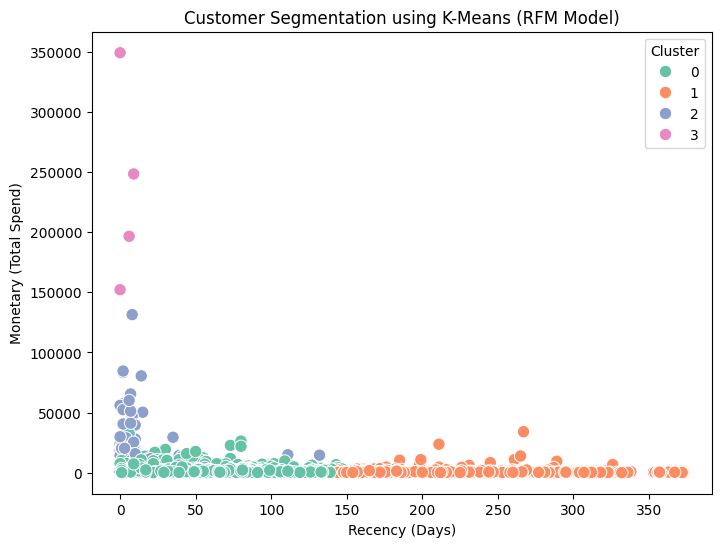

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='recency', y='monetary', hue='cluster', palette='Set2', s=80)
plt.title('Customer Segmentation using K-Means (RFM Model)')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()


##Question 3 – Cross-Selling Opportunities

Prepare Basket Data

In [17]:
basket = (retail_df
          .groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().fillna(0))


basket = basket.applymap(lambda x: 1 if x > 0 else 0)


print("Basket data shape:", basket.shape)
basket.head()

/tmp/ipython-input-2011280971.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Basket data shape: (19215, 4444)


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,...,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Association Rule Mining

In [18]:
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.sort_values('lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
28,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.052511,0.042571,0.028832,0.549058,12.897504,1.0,0.026596,2.123178,0.973590,0.435192,0.529008,0.613160
29,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.042571,0.052511,0.028832,0.677262,12.897504,1.0,0.026596,2.935780,0.963482,0.435192,0.659375,0.613160
25,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.042050,0.069477,0.032371,0.769802,11.079959,1.0,0.029449,4.042272,0.949682,0.408941,0.752614,0.617860
24,(STRAWBERRY CERAMIC TRINKET BOX),(SWEETHEART CERAMIC TRINKET BOX),0.069477,0.042050,0.032371,0.465918,11.079959,1.0,0.029449,1.793636,0.977673,0.408941,0.442473,0.617860
7,(CHOCOLATE HOT WATER BOTTLE),(HOT WATER BOTTLE TEA AND SYMPATHY),0.041686,0.043768,0.020088,0.481898,11.010301,1.0,0.018264,1.845643,0.948725,0.307325,0.458183,0.470438
6,(HOT WATER BOTTLE TEA AND SYMPATHY),(CHOCOLATE HOT WATER BOTTLE),0.043768,0.041686,0.020088,0.458977,11.010301,1.0,0.018264,1.771301,0.950790,0.307325,0.435443,0.470438
9,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.045485,0.051887,0.025553,0.561785,10.827178,1.0,0.023193,2.163580,0.950891,0.355797,0.537803,0.527131
8,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.051887,0.045485,0.025553,0.492477,10.827178,1.0,0.023193,1.880734,0.957311,0.355797,0.468293,0.527131
19,(LUNCH BAG SPACEBOY DESIGN ),(LUNCH BAG SUKI DESIGN ),0.047307,0.049649,0.023627,0.499450,10.059676,1.0,0.021279,1.898614,0.945313,0.322214,0.473300,0.487670
18,(LUNCH BAG SUKI DESIGN ),(LUNCH BAG SPACEBOY DESIGN ),0.049649,0.047307,0.023627,0.475891,10.059676,1.0,0.021279,1.817739,0.947642,0.322214,0.449866,0.487670


Visualization

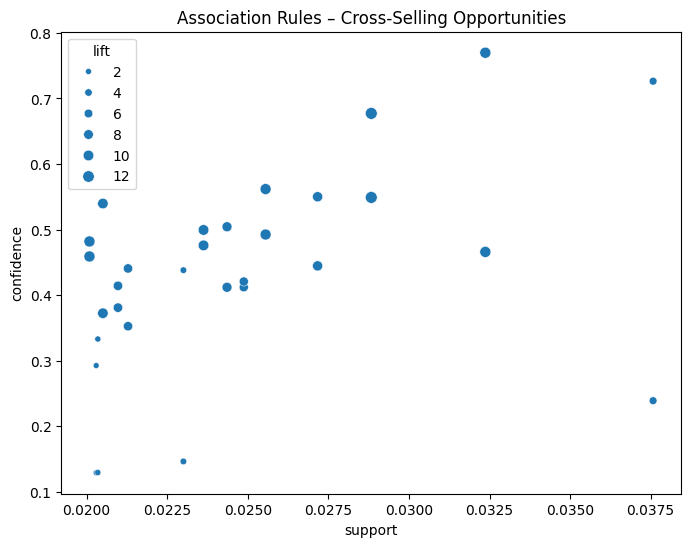

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules)
plt.title('Association Rules – Cross-Selling Opportunities')
plt.show()


Combined Summary Output

In [20]:
summary = pd.DataFrame({
    'Question': ['Churn Prediction', 'Customer Segmentation', 'Cross-Selling'],
    'Algorithm': ['Random Forest', 'K-Means', 'Apriori'],
    'Goal': ['Predict churn likelihood', 'Group customers by RFM behavior', 'Find product associations'],
    'Key Metric': ['Accuracy/AUC', 'Cluster Means', 'Lift/Support']
})
display(summary)


,Question,Algorithm,Goal,Key Metric
0,Churn Prediction,Random Forest,Predict churn likelihood,Accuracy/AUC
1,Customer Segmentation,K-Means,Group customers by RFM behavior,Cluster Means
2,Cross-Selling,Apriori,Find product associations,Lift/Support


Churn Rate by Contract Type

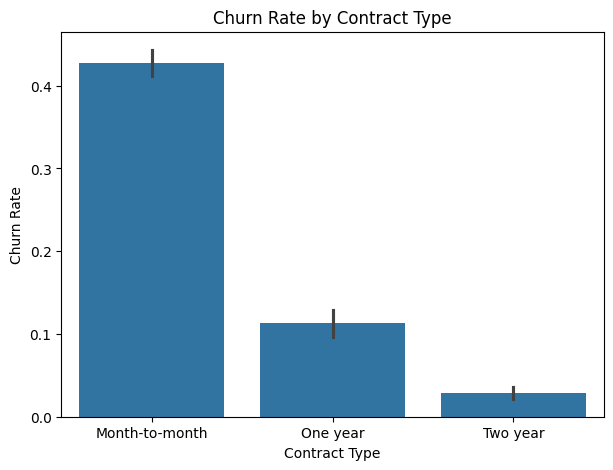

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


churn_raw = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

plt.figure(figsize=(7,5))
sns.barplot(data=churn_raw, x='Contract', y=churn_raw['Churn'].apply(lambda x: 1 if x=='Yes' else 0))
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.show()


RFM Heatmap (Customer Segmentation Correlation)

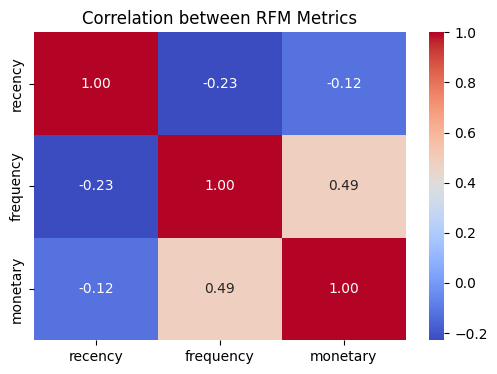

In [25]:

plt.figure(figsize=(6,4))
sns.heatmap(rfm[['recency','frequency','monetary']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between RFM Metrics')
plt.show()


Top Product Co-Occurrences Network (Cross-Selling)

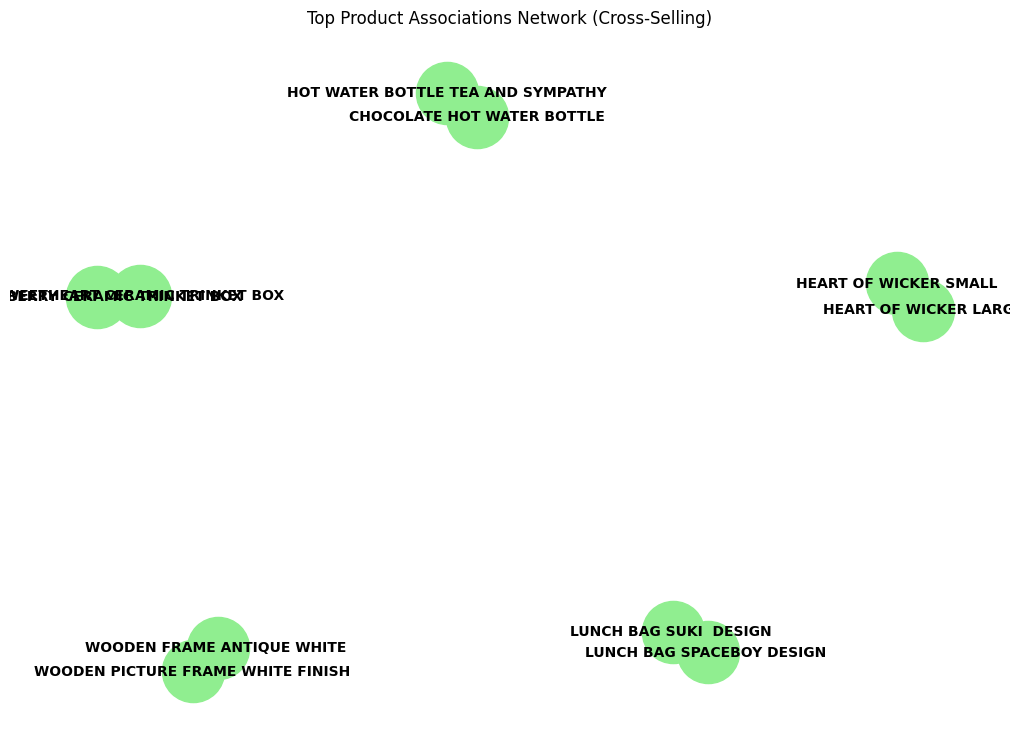

In [26]:
import networkx as nx


top_rules = rules.sort_values('lift', ascending=False).head(10)


G = nx.Graph()
for _, row in top_rules.iterrows():
    for a in row['antecedents']:
        for b in row['consequents']:
            G.add_edge(a, b, weight=row['lift'])


plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos,
        with_labels=True,
        node_size=2000,
        node_color='lightgreen',
        font_size=10,
        font_weight='bold',
        edge_color='gray')
plt.title('Top Product Associations Network (Cross-Selling)')
plt.show()
